<a href="https://colab.research.google.com/github/luizmiguelgr/Fake-News-Detection-NLP/blob/main/NLP_Ligia_%7C_Luiz_Miguel_Gonzaga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers scikit-learn

In [1]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import re
import os
import pickle
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Centralizando os hiperparâmetros
MAX_LEN = 512
BATCH_SIZE = 32 # Lote para extração
EMBEDDING_DIM = 768

In [ ]:
# Arquivos do projeto
EMBEDDINGS_FILE = "bert_embeddings.dat"
CLASSIFIER_MODEL = "bilstm_classifier.keras"
TOKENIZER_PATH = "distilbert_tokenizer"
MODEL_CONFIG_FILE = "model_metadata.pkl"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/NLP Ligia | Luiz Miguel Gonzaga | FAKE NEWS Detection"

train_path = f"{BASE_PATH}/train.csv"
test_path = f"{BASE_PATH}/test.csv"

df = pd.read_csv(train_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **EDA**

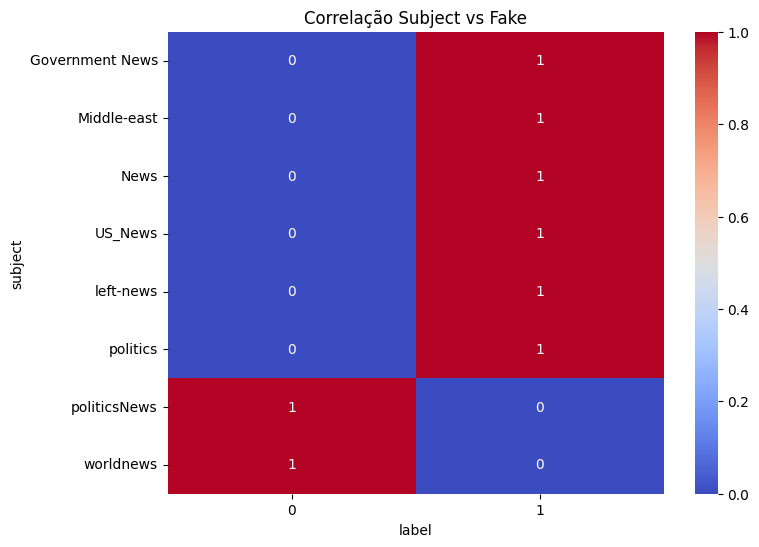

In [3]:
plt.figure(figsize=(8,6))
ct = pd.crosstab(df["subject"], df["label"], normalize="index")
sns.heatmap(ct, annot=True, cmap="coolwarm")
plt.title("Correlação Subject vs Fake")
plt.show()

df_model = df.drop(columns=["subject", "date", "id"])
# Análise da correlação entre o veículo de notícias e a quantidade de casos verdadeiros e falsos

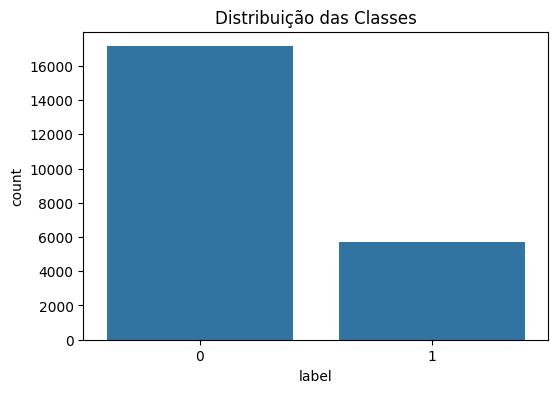

label
0    0.75
1    0.25
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_model, x="label")
plt.title("Distribuição das Classes")
plt.show()

print(df_model["label"].value_counts(normalize=True))

In [ ]:
df_model["title_len"] = df_model["title"].str.split().apply(len)
df_model["text_len"] = df_model["text"].str.split().apply(len)

print(df_model[["title_len","text_len"]].describe(percentiles=[0.5,0.75,0.9,0.95,0.99]))
# Dados Estatísticos, do tamanho do título e texto

          title_len      text_len
count  22844.000000  22844.000000
mean      11.139030    396.941429
std        3.346776    316.990996
min        1.000000      0.000000
50%       10.000000    362.000000
75%       12.000000    520.000000
90%       15.000000    766.000000
95%       18.000000    901.000000
99%       23.570000   1276.000000
max       42.000000   8135.000000


In [ ]:
df.head()

,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0
3,15368,Biden asks U.S. Congress to allow unencumbered...,WASHINGTON (Reuters) - Vice President Joe Bide...,politicsNews,"September 8, 2016",0
4,6934,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,Donald Trump kicked off his Monday morning by ...,News,"February 6, 2017",1


In [ ]:
# Junta todos os textos, junta as palavras mais ditas, a frequência de cada
texto_total = " ".join(df["text"].dropna())
palavras = texto_total.split()
from collections import Counter
contagem = Counter(palavras)
print(contagem.most_common(40))

[('the', 457745), ('to', 266159), ('of', 221478), ('a', 200029), ('and', 196678), ('in', 173766), ('on', 103110), ('that', 100345), ('for', 84457), ('is', 69611), ('s', 67380), ('said', 63024), ('with', 57210), ('was', 54546), ('The', 54456), ('he', 50149), ('by', 49033), ('as', 49003), ('has', 47180), ('Trump', 45000), ('his', 43142), ('from', 40855), ('it', 40302), ('have', 40293), ('be', 38831), ('not', 38295), ('at', 34008), ('an', 33554), ('U.S.', 32608), ('who', 31807), ('are', 31775), ('would', 30602), ('will', 25448), ('had', 25447), ('-', 24895), ('they', 23161), ('this', 22910), ('been', 21262), ('about', 21145), ('which', 20611)]


### **Pré-processamento**

In [ ]:
df = df.drop(columns=["subject", "date"], errors="ignore")

def clean_text_light(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\(?reuters\)?\s*-?", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_light"] = (df["title"] + " " + df["text"]).apply(clean_text_light)

X_text = df["text_light"].values
y = df["label"].values
N_SAMPLES = len(X_text)
# Remove Link, veículo de notícias, múltiplos espaços

### **Extranindo Embbedings: BERT e MEMMAP**

In [ ]:
# Carrega tokenizer e modelo DistilBERT pré-treinado
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()  # Modo avaliação (desativa dropout)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
# Se já existe arquivo antigo de embeddings, remove
if os.path.exists(EMBEDDINGS_FILE):
    os.remove(EMBEDDINGS_FILE)

In [ ]:
# Aloca espaço no disco
X_memmap = np.memmap(
    EMBEDDINGS_FILE,
    dtype="float32",
    mode="w+",
    shape=(N_SAMPLES, MAX_LEN, EMBEDDING_DIM)
)

In [ ]:
# Trunca texto: pega 382 do começo e 128 do final se passar de 512 tokens
def smart_truncate(text, tokenizer, max_len=512):
    limit = max_len - 2
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if len(tokens) <= limit:
        return tokenizer.encode(text, max_length=max_len, padding="max_length", truncation=True)
    head = tokens[:382]
    tail = tokens[-128:]
    return [tokenizer.cls_token_id] + head + tail + [tokenizer.sep_token_id]

In [ ]:
for i in tqdm(range(0, N_SAMPLES, BATCH_SIZE)):
    batch_texts = X_text[i : i + BATCH_SIZE]

    input_ids = []
    attention_masks = []

    for text in batch_texts:
        ids = smart_truncate(text, tokenizer, MAX_LEN)
        # Pad manual
        if len(ids) < MAX_LEN:
            ids = ids + [tokenizer.pad_token_id] * (MAX_LEN - len(ids))

        mask = [1 if token != tokenizer.pad_token_id else 0 for token in ids]
        input_ids.append(ids)
        attention_masks.append(mask)

    input_ids_pt = torch.tensor(input_ids).to(device)
    attention_masks_pt = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids_pt, attention_mask=attention_masks_pt)
        batch_embeddings = outputs.last_hidden_state

        # Aplica a máscara para zerar padding
        mask_expanded = attention_masks_pt.unsqueeze(-1).expand(batch_embeddings.size()).float()
        batch_embeddings = batch_embeddings * mask_expanded

        # Escreve no Memmap (Disco)
        # O .cpu().numpy() tira da GPU e joga pro disco via memmap
        X_memmap[i : i + len(batch_texts)] = batch_embeddings.cpu().numpy()

        # Força gravação no disco para liberar RAM
        X_memmap.flush()

# Limpa GPU
del bert_model
torch.cuda.empty_cache()

100%|██████████| 714/714 [09:48<00:00,  1.21it/s]


### **Gerador e Split**

In [ ]:
class MemmapGenerator(tf.keras.utils.Sequence):

    def __init__(self, memmap_data, indices, labels, batch_size=16):
        self.memmap_data = memmap_data
        self.indices = indices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.memmap_data[batch_indices]
        y_batch = self.labels[batch_indices]
        return X_batch, y_batch


indices = np.arange(N_SAMPLES)

In [ ]:
train_idx, val_idx, y_train_split, y_val_split = train_test_split(
    indices, y, test_size=0.2, stratify=y, random_state=42
)

weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(y_train_split),
    y=y_train_split
)

class_weights = dict(zip(np.unique(y_train_split), weights))

X_memmap_read = np.memmap(
    EMBEDDINGS_FILE,
    dtype="float32",
    mode="r",
    shape=(N_SAMPLES, MAX_LEN, EMBEDDING_DIM)
)

train_gen = MemmapGenerator(X_memmap_read, train_idx, y, batch_size=16)
val_gen = MemmapGenerator(X_memmap_read, val_idx, y, batch_size=16)

### **Treinamento**

In [ ]:
def build_lstm_classifier():

    # Modelo recebe embeddings do BERT (MAX_LEN x 768) e usa BiLSTM para capturar contexto
    inputs = tf.keras.Input(shape=(MAX_LEN, EMBEDDING_DIM))
    x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


model = build_lstm_classifier()

# Callbacks para salvar melhor modelo e parar treino se não melhorar
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_lstm.keras",
    monitor="val_loss",
    save_best_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Treina o classificador usando embeddings pré-gerados
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 192s 163ms/step - accuracy: 0.9769 - loss: 0.0630 - val_accuracy: 0.9989 - val_loss: 0.0044
Epoch 2/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 185s 162ms/step - accuracy: 0.9989 - loss: 0.0026 - val_accuracy: 0.9991 - val_loss: 0.0025
Epoch 3/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 184s 161ms/step - accuracy: 0.9997 - loss: 6.0410e-04 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 4/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 185s 162ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9993 - val_loss: 0.0027
Epoch 5/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 186s 163ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9996 - val_loss: 8.1786e-04
Epoch 6/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 187s 163ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9993 - val_loss: 9.9200e-04
Epoch 7/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 196s 171ms/step - accuracy: 1.0000 - loss: 7.8281e-05 - val_accuracy: 0.9991 - val_loss: 0.0024
Epoch 8/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 186s

### **Avaliação e Limite**

In [ ]:
y_pred_prob = model.predict(val_gen)
y_true_val = y[val_idx]

thresholds = np.arange(0.1, 0.9, 0.01)

f1_scores = [
    f1_score(y_true_val, (y_pred_prob > t).astype(int))
    for t in thresholds
]

best_thresh = thresholds[np.argmax(f1_scores)]

print("Melhor Threshold:", best_thresh)
print("Melhor F1:", max(f1_scores))
print(classification_report(
    y_true_val,
    (y_pred_prob > best_thresh).astype(int),
    digits=4
))

NameError: name 'model' is not defined

### **Salvar**

In [ ]:
model.save(MODEL_FILE)
tokenizer.save_pretrained(TOKENIZER_FOLDER)

configuracoes = {
    "best_threshold": best_thresh,
    "max_len": MAX_LEN
}

with open(CONFIG_FILE, "wb") as f:
    pickle.dump(configuracoes, f)

### **Interpretação das Métricas**

In [ ]:
from sklearn.metrics import matthews_corrcoef, precision_recall_curve

y_pred_final = (y_pred_prob > best_thresh).astype(int)
mcc = matthews_corrcoef(y_true_val, y_pred_final)
print("MCC:", mcc)

precision, recall, _ = precision_recall_curve(y_true_val, y_pred_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

def analyze_sensitivity(sample_index, remove_tokens=50):
    original_embedding = X_memmap_read[sample_index:sample_index+1]
    original_prob = model.predict(original_embedding)[0][0]

    perturbed_embedding = original_embedding.copy()
    perturbed_embedding[:, :remove_tokens, :] = 0

    new_prob = model.predict(perturbed_embedding)[0][0]

    print("Prob original:", float(original_prob))
    print("Prob perturbado:", float(new_prob))
    print("Variação:", abs(float(original_prob - new_prob)))

### **Pipeline para novo conjunto**

In [ ]:
with open(CONFIG_FILE, "rb") as f:
    configuracoes = pickle.load(f)

best_thresh = configuracoes["best_threshold"]
MAX_LEN = configuracoes["max_len"]

tokenizer = DistilBertTokenizer.from_pretrained(TOKENIZER_FOLDER)
model = tf.keras.models.load_model(MODEL_FILE)

bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()

df_test = pd.read_csv("test.csv")
df_test["title"] = df_test["title"].fillna("")
df_test["text"] = df_test["text"].fillna("")

df_test["text_light"] = (df_test["title"] + " " + df_test["text"]).apply(clean_text_light)
X_test_text = df_test["text_light"].values

todas_probabilidades = []

for i in tqdm(range(0, len(X_test_text), BATCH_SIZE)):
    batch_texts = X_test_text[i:i+BATCH_SIZE]

    input_ids, attention_masks = [], []

    for text in batch_texts:
        ids = smart_truncate(text, tokenizer, MAX_LEN)
        if len(ids) < MAX_LEN:
            ids += [tokenizer.pad_token_id] * (MAX_LEN - len(ids))
        mask = [1 if token != tokenizer.pad_token_id else 0 for token in ids]
        input_ids.append(ids)
        attention_masks.append(mask)

    input_ids_pt = torch.tensor(input_ids).to(device)
    attention_masks_pt = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids_pt, attention_mask=attention_masks_pt)
        embeddings = outputs.last_hidden_state
        mask_expanded = attention_masks_pt.unsqueeze(-1).expand(embeddings.size()).float()
        embeddings = embeddings * mask_expanded

    preds = model.predict(embeddings.cpu().numpy(), verbose=0)
    todas_probabilidades.extend(preds.flatten())

y_pred_test = (np.array(todas_probabilidades) > best_thresh).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_test
})

submission.to_csv("submission.csv", index=False)